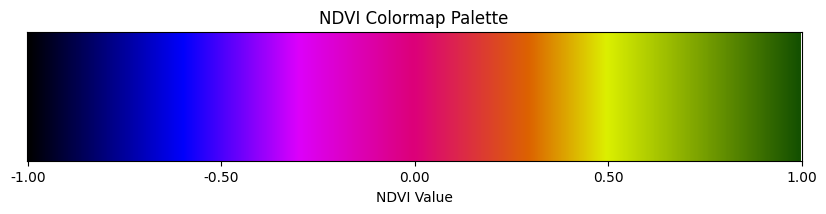

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2
import os
def modern_ldp_ndvi_colormap(ndvi):
    """
    Apply a Modern LDP NDVI Scale colormap using smooth gradients.
    NDVI is normalized from -1 to 1 and mapped to the corresponding colormap.
    """

    # Normalize NDVI to [0, 1]
    ndvi_normalized = np.clip((ndvi + 1) / 2, 0, 1)

    # Initialize the RGB image
    colored_ndvi = np.zeros((ndvi.shape[0], ndvi.shape[1], 3), dtype=np.uint8)

    # Color transitions (interpolating between these colors)
    

    # Black to Blue (NDVI in range [-1, -0.6])
    mask_black_to_blue = (ndvi < -0.6)
    ndvi_black_to_blue = (ndvi - (-1)) / (-0.6 - (-1))  # Normalizing to [0, 1]
    colored_ndvi[mask_black_to_blue] = np.stack([
        np.zeros_like(ndvi_black_to_blue[mask_black_to_blue]),  # Red channel
        np.zeros_like(ndvi_black_to_blue[mask_black_to_blue]),  # Green channel
        (ndvi_black_to_blue[mask_black_to_blue] * 251).astype(np.uint8),  # Blue channel
    ], axis=-1)

    # Blue to Purple (NDVI in range [-0.6, -0.3])
    mask_blue_to_purple = (ndvi >= -0.6) & (ndvi < -0.3)
    ndvi_blue_to_purple = (ndvi[mask_blue_to_purple] + 0.6) / (0.3)  # Normalize to [0, 1]
    colored_ndvi[mask_blue_to_purple] = np.stack([
        (ndvi_blue_to_purple*220).astype(np.uint8),  # Red channel
        np.zeros_like(ndvi_blue_to_purple, dtype=np.uint8),  # Green channel
        251*np.ones_like(ndvi_blue_to_purple, dtype=np.uint8),  # Blue channel
    ], axis=-1)

    # Pruple to Pink (NDVI in range [-0.3, 0])
    mask_purple_to_pink = (ndvi >= -0.3) & (ndvi < 0)
    ndvi_purple_to_pink = (ndvi[mask_purple_to_pink] + 0.3) / (0.3)  # Normalize to [0, 1]
    colored_ndvi[mask_purple_to_pink] = np.stack([
        220*np.ones_like(ndvi_purple_to_pink, dtype=np.uint8),  # Red channel
        np.zeros_like(ndvi_purple_to_pink, dtype=np.uint8),  # Green channel
        (251 - ndvi_purple_to_pink * 131).astype(np.uint8),  # Blue channel
    ], axis=-1)


    # Pink to Dark Orange (NDVI in range [0, 0.25])
    mask_pink_to_orange = (ndvi >= 0) & (ndvi < 0.3)
    ndvi_pink_to_orange = (ndvi[mask_pink_to_orange]) / (0.3)  # Normalize to [0, 1]
    colored_ndvi[mask_pink_to_orange] = np.stack([
        220*np.ones_like( ndvi_pink_to_orange , dtype=np.uint8),  # Red channel (darkens)
        (ndvi_pink_to_orange * 100).astype(np.uint8),  # Green channel (darkens)
        (124 - ( ndvi_pink_to_orange  * 124)).astype(np.uint8),  # Blue channel
    ], axis=-1)

    # Dark Orange to Yellow (NDVI in range [0.25, 0.4])
    mask_orange_to_yellow = (ndvi >= 0.3) & (ndvi < 0.5)
    ndvi_orange_to_yellow = (ndvi[mask_orange_to_yellow] - 0.3) / (0.2)  # Normalize to [0, 1]
    colored_ndvi[mask_orange_to_yellow] = np.stack([
        220*np.ones_like(ndvi_orange_to_yellow, dtype=np.uint8),  # Red channel (orange -> yellow)
        ((ndvi_orange_to_yellow * 140)+100).astype(np.uint8),  # Green channel (yellow)
        np.zeros_like(ndvi_orange_to_yellow, dtype=np.uint8),  # Blue channel (none)
    ], axis=-1)

    # Yellow to Green (NDVI in range [0.5, 1])
    mask_yellow_to_green = (ndvi >= 0.5)
    ndvi_yellow_to_green = (ndvi[mask_yellow_to_green] - 0.5) / (0.5)  # Normalize to [0, 1]
    colored_ndvi[mask_yellow_to_green] = np.stack([
        (220 - (ndvi_yellow_to_green * 200)).astype(np.uint8),  # Red channel (none)
        (240 - (ndvi_yellow_to_green * 160)).astype(np.uint8),  # Green channel (from yellow to green)
        np.zeros_like(ndvi_yellow_to_green, dtype=np.uint8),  # Blue channel (none)
    ], axis=-1)

    return colored_ndvi

def generate_ndvi_palette(colormap_function, ndvi_range=(-1, 1), width=300, height=50):
    """
    Generate and display a palette for the NDVI colormap.

    Parameters:
        colormap_function (function): The NDVI colormap function to apply.
        ndvi_range (tuple): Range of NDVI values, typically (-1, 1).
        width (int): Width of the palette image.
        height (int): Height of the palette image.
    """
    # Create a gradient of NDVI values
    ndvi_values = np.linspace(ndvi_range[0], ndvi_range[1], width).reshape(1, -1)
    ndvi_values = np.tile(ndvi_values, (height, 1))  # Repeat vertically for visualization

    # Apply the colormap function
    colored_ndvi = colormap_function(ndvi_values)

    # Display the palette
    plt.figure(figsize=(10, 2))
    plt.imshow(colored_ndvi)
    plt.xticks(
        ticks=np.linspace(0, width, 5),
        labels=[f"{v:.2f}" for v in np.linspace(ndvi_range[0], ndvi_range[1], 5)]
    )
    plt.yticks([])  # Hide y-axis ticks
    plt.xlabel("NDVI Value")
    plt.title("NDVI Colormap Palette")
    plt.show()

# Example usage
generate_ndvi_palette(modern_ldp_ndvi_colormap)

def compute_ndvi(red_band, nir_band):
    # Ensure the images are of the same shape (height, width)
    if red_band.shape != nir_band.shape:
        raise ValueError("The Red and NIR band images must have the same dimensions.")
    
    # Calculate NDVI
    red_band = red_band.astype(np.float32)
    nir_band = nir_band.astype(np.float32)
    ndvi = (nir_band - red_band) / (nir_band + red_band + 1e-10)
   
    colored_ndvi = modern_ldp_ndvi_colormap(ndvi)
    
    return ndvi, colored_ndvi
# Function for FFT-based cross-correlation
def fft_cross_correlation(image1, image2):
    f1 = fft2(image1)
    f2 = fft2(image2)
    cross_power = (f1 * f2.conjugate()) / np.abs(f1 * f2.conjugate())
    correlation = np.abs(ifft2(cross_power))
    return correlation

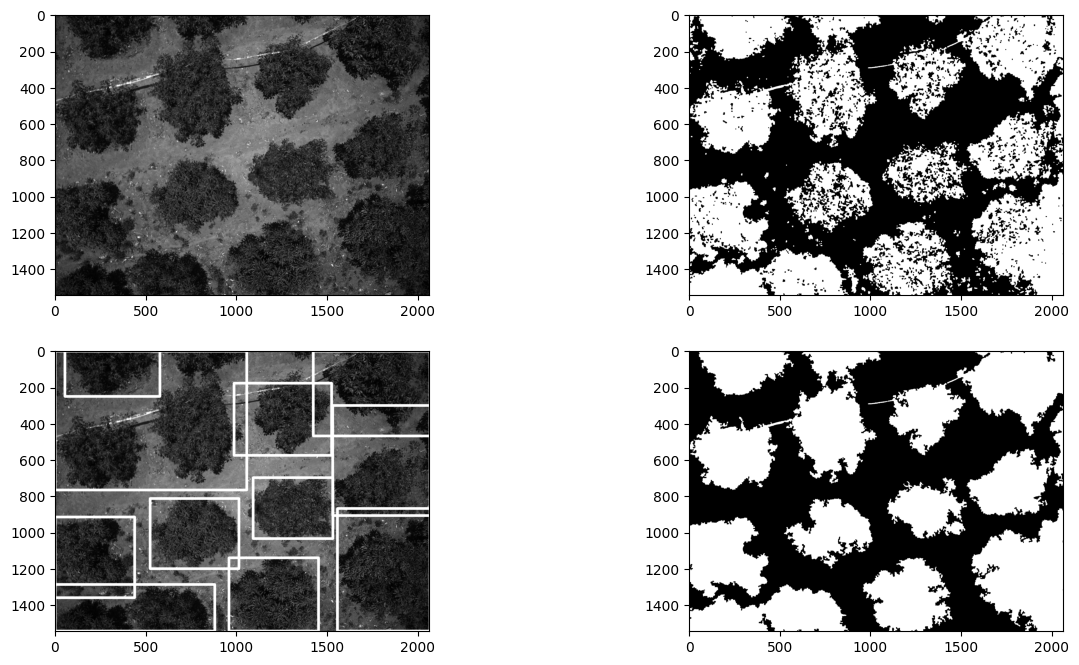

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detection_trees_pdi(image_base_name, band_index, show = False):
    green_filename = image_base_name + f"_{band_index}.tif"
    image_green = cv2.imread(green_filename, cv2.IMREAD_GRAYSCALE)

# Aplicar el método de Otsu
# Nota: No es necesario especificar el valor de umbral, se ignora (0)
    #_, mascara = cv2.threshold(image_green, 0, 255, cv2.THRESH_BINARY_INV  + cv2.THRESH_OTSU)

    _, mascara = cv2.threshold(image_green, 68, 255, cv2.THRESH_BINARY_INV)

    kernel = np.ones((5,5), np.uint8)

    mascara = cv2.morphologyEx(mascara, cv2.MORPH_OPEN, kernel, iterations = 1)
    mascara = cv2.morphologyEx(mascara, cv2.MORPH_CLOSE, kernel, iterations= 1)
    #mascara = cv2.dilate(mascara, kernel , iterations = 1)
    #mascara = cv2.erode(mascara, kernel , iterations = 2)
    #mascara = cv2.dilate(mascara, kernel , iterations = 1)
    countorus, _  = cv2.findContours(mascara, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    final_contours = []
    bboxes = []
    masks = []
    im_bboxes = image_green.copy()

    for cn in countorus:
        area_cn = cv2.contourArea(cn)
        if area_cn > 65000:
            final_contours.append(cn)
            x, y, w, h = cv2.boundingRect(cn)
            image_mask_tree = np.zeros_like(mascara, dtype= mascara.dtype)
            cv2.drawContours(image_mask_tree, [cn], -1, color = 255, thickness = cv2.FILLED)
            masks.append(image_mask_tree)
            bboxes.append([x,y,w,h])
            #print("area:", area_cn)
            cv2.rectangle(im_bboxes, (x,y), (x + w, y + h), (255,0,0), 14)
    mascara_filtrada = np.zeros_like(mascara, np.uint8)
    cv2.drawContours(mascara_filtrada, final_contours, -1, color = 255, thickness = cv2.FILLED)
    if show:
        fig, axis = plt.subplots(2,2 , figsize = (15,8))
        axis[0][0].imshow(image_green, 'gray')
        axis[0][1].imshow(mascara, cmap = 'gray')
        axis[1][0].imshow(im_bboxes, 'gray')
        axis[1][1].imshow(mascara_filtrada, cmap = 'gray')
    full_mask = mascara_filtrada
    return bboxes, masks, full_mask

image_base_name = './data/campo2/vuelo2/mutiespectral\\IMG_0581'
bboxes, masks, full_mask = detection_trees_pdi(image_base_name, 2, show = True)

In [4]:
def aligned_band(reference_band, new_band):
    correlation = fft_cross_correlation(reference_band, new_band)
    y_shift, x_shift = np.unravel_index(np.argmax(correlation), correlation.shape)
    # Step 3: Apply Shift to Align the Red Image
    rows, cols = reference_band.shape
    M = np.float32([[1, 0, x_shift], [0, 1, y_shift]])  
    aligned_new_band = cv2.warpAffine(new_band, M, (cols, rows))
    aligned_new_band = aligned_new_band[x_shift+1:, y_shift+1:]
    image_red = image_red[x_shift+1:, y_shift+1:]

Detected shift: (y_shift=7, x_shift=0)
Detected shift: (y_shift=20, x_shift=24)
Detected shift: (y_shift=17, x_shift=17)


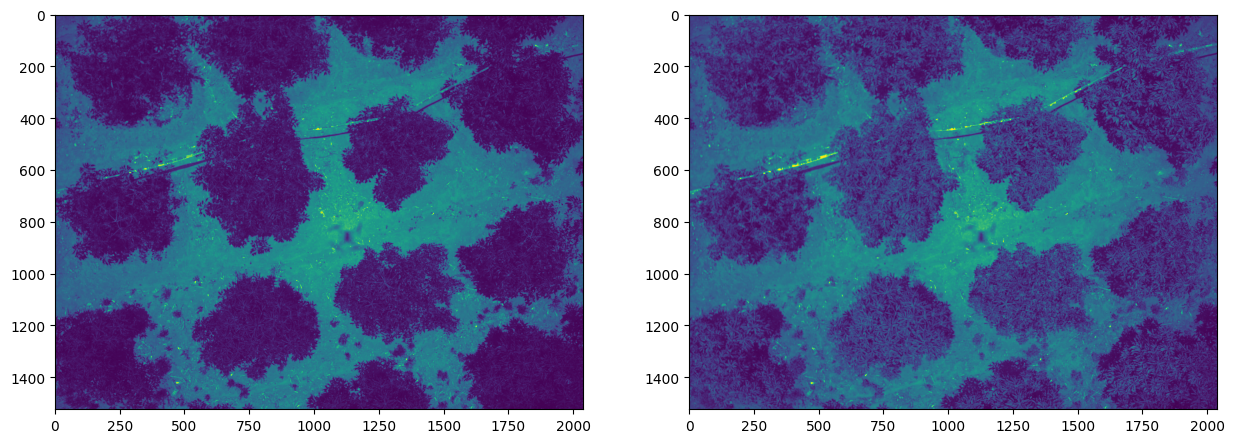

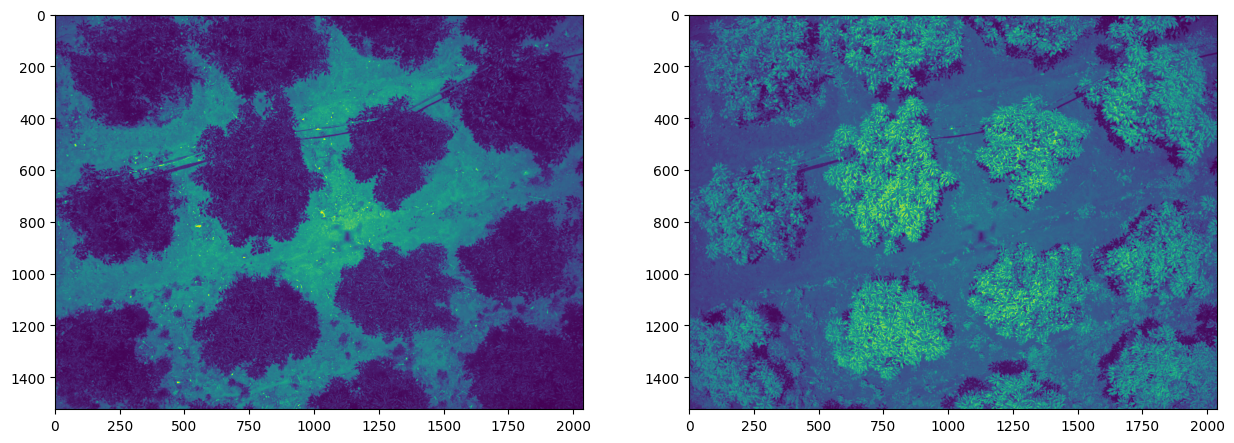

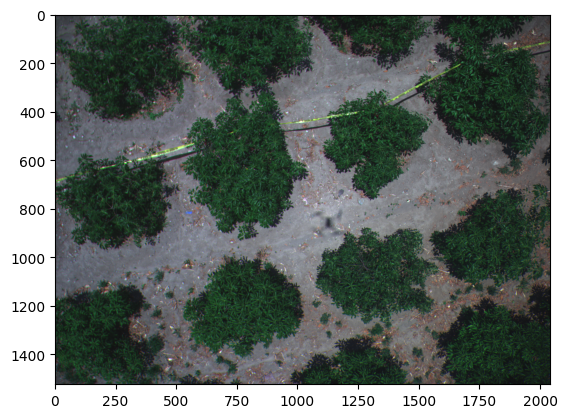

In [5]:
import cv2
import numpy as np
from scipy.signal import correlate2d
from glob import glob

#def fft_cross_correlation(image1, image2):
#    """
#    Realiza la correlación cruzada entre dos imágenes.
#    """
#    image1 = image1 - np.mean(image1)
#    image2 = image2 - np.mean(image2)
#    f1 = np.fft.fft2(image1)
#    f2 = np.fft.fft2(image2)
#    cross_power_spectrum = f1 * f2.conjugate()
#    result = np.fft.ifft2(cross_power_spectrum / np.abs(cross_power_spectrum))
#    return np.abs(result)

def align_band(reference, target):
    """
    Alinea una banda `target` con respecto a la banda `reference`.
    """
    correlation = fft_cross_correlation(reference, target)
    y_shift, x_shift = np.unravel_index(np.argmax(correlation), correlation.shape)

    print(f"Detected shift: (y_shift={y_shift}, x_shift={x_shift})")

    # Step 3: Apply Shift to Align the Red Image
    rows, cols = reference.shape
    M = np.float32([[1, 0, x_shift], [0, 1, y_shift]])  
    aligned_target = cv2.warpAffine(target, M, (cols, rows))
    return aligned_target, (y_shift, x_shift)

images_dir = "./data/campo2/vuelo2/mutiespectral/*.tif"

images_paths = glob(images_dir)
image_names = list(set(["_".join(filepath.split("_")[:2]) for filepath in images_paths ]))

bands_indexes = {"BLUE": 1 ,"GREEN": 2 ,'RED': 3 ,"NIR": 4, "RED-EDGE": 5, "PANCROMATIC": 6 }

image_base_name = image_names[0]

# Create filenames based on the naming convention
red_filename = image_base_name + f"_{bands_indexes['RED']}.tif"
nir_filename = image_base_name + f"_{bands_indexes['NIR']}.tif"
red_filename = image_base_name + f"_{bands_indexes['RED']}.tif"
nir_filename = image_base_name + f"_{bands_indexes['NIR']}.tif"
red_filename = image_base_name + f"_{bands_indexes['RED']}.tif"
nir_filename = image_base_name + f"_{bands_indexes['NIR']}.tif"

# Bandas iniciales
band_blue = cv2.imread(image_base_name + f"_{bands_indexes['BLUE']}.tif", cv2.IMREAD_GRAYSCALE)  # Banda azul
band_green = cv2.imread(image_base_name + f"_{bands_indexes['GREEN']}.tif", cv2.IMREAD_GRAYSCALE) # Banda verde
band_red = cv2.imread(image_base_name + f"_{bands_indexes['RED']}.tif", cv2.IMREAD_GRAYSCALE)
band_nir = cv2.imread(image_base_name + f"_{bands_indexes['NIR']}.tif", cv2.IMREAD_GRAYSCALE)   # Banda NIR

# Alinear las bandas respecto a la banda roja
aligned_bands = [band_red]
shifts = []

for band in [band_green, band_blue, band_nir]:
    aligned_band, shift = align_band(aligned_bands[0], band)
    aligned_bands.append(aligned_band)
    shifts.append(shift)

# Recorte final para evitar bordes no válidos
# Calcular el área común después del desplazamiento
x_min = max(shift[1] for shift in shifts)  #
y_min = max(shift[0] for shift in shifts)  #

aligned_bands = [band[y_min:, x_min:] for band in aligned_bands]

fig, axis = plt.subplots(1,2 , figsize = (15,8))
axis[0].imshow(aligned_bands[0])
axis[1].imshow(aligned_bands[1])

fig, axis = plt.subplots(1,2 , figsize = (15,8))
axis[0].imshow(aligned_bands[2])
axis[1].imshow(aligned_bands[3])
plt.show()
plt.imshow(np.array(aligned_bands[:3]).transpose(1,2,0))

In [35]:
from glob import glob
images_dir = "./data/campo2/vuelo2/mutiespectral/*.tif"

images_paths = glob(images_dir)
bands_indexes = {"BLUE": 1 ,"GREEN": 2 ,'RED': 3 ,"NIR": 4, "RED-EDGE": 5, "PANCROMATIC": 6 }
output_dir  = "./ndvi_aligned/"
os.makedirs(output_dir,exist_ok=True)
image_names = list(set(["_".join(filepath.split("_")[:2]) for filepath in images_paths ]))
print("image_names:", image_names)
# Loop through the image pairs

for i in range(len(image_names)):
    image_base_name = image_names[i]
    # Create filenames based on the naming convention
    red_filename = image_base_name + f"_{bands_indexes['RED']}.tif"
    nir_filename = image_base_name + f"_{bands_indexes['NIR']}.tif"
    
    # Load the images using OpenCV
    image_red = cv2.imread(red_filename, cv2.IMREAD_GRAYSCALE)
    image_nir = cv2.imread(nir_filename, cv2.IMREAD_GRAYSCALE)
    
    # Create filenames based on the naming convention
    red_filename = image_base_name + f"_{bands_indexes['RED']}.tif"
    nir_filename = image_base_name + f"_{bands_indexes['NIR']}.tif"
    red_filename = image_base_name + f"_{bands_indexes['RED']}.tif"
    nir_filename = image_base_name + f"_{bands_indexes['NIR']}.tif"
    red_filename = image_base_name + f"_{bands_indexes['RED']}.tif"
    nir_filename = image_base_name + f"_{bands_indexes['NIR']}.tif"

    # Bandas iniciales
    band_blue = cv2.imread(image_base_name + f"_{bands_indexes['BLUE']}.tif", cv2.IMREAD_GRAYSCALE)  # Banda azul
    band_green = cv2.imread(image_base_name + f"_{bands_indexes['GREEN']}.tif", cv2.IMREAD_GRAYSCALE) # Banda verde
    band_red = cv2.imread(image_base_name + f"_{bands_indexes['RED']}.tif", cv2.IMREAD_GRAYSCALE)
    band_nir = cv2.imread(image_base_name + f"_{bands_indexes['NIR']}.tif", cv2.IMREAD_GRAYSCALE)   # Banda NIR

    # Alinear las bandas respecto a la banda roja
    aligned_bands = [band_red]
    shifts = []

    for band in [band_green, band_blue, band_nir]:
        aligned_band, shift = align_band(aligned_bands[0], band)
        aligned_bands.append(aligned_band)
        shifts.append(shift)

    # Recorte final para evitar bordes no válidos
    # Calcular el área común después del desplazamiento
    x_min = max(shift[1] for shift in shifts)  #
    y_min = max(shift[0] for shift in shifts)  #

    aligned_bands = [band[y_min:, x_min:] for band in aligned_bands]

    aligned_nir = aligned_bands[3]
    aligned_red = aligned_bands[0]

    
    ndvi, colored_ndvi = compute_ndvi(aligned_red, aligned_nir)

    bboxes, masks, full_mask = detection_trees_pdi(image_base_name, 2, show = False)

    full_mask = full_mask[y_min:, x_min:]

    seg_ndvi = cv2.bitwise_and(ndvi, ndvi, mask = full_mask)

    # Save the colored NDVI image
    output_filename = output_dir + f"NDVI_00{i:02d}.png"
    cv2.imwrite(output_filename,  cv2.cvtColor(colored_ndvi, cv2.COLOR_RGB2BGR))

    print(f"Saved NDVI image for pair {i} as {output_filename}")

image_names: ['./data/campo2/vuelo2/mutiespectral\\IMG_0582', './data/campo2/vuelo2/mutiespectral\\IMG_0581']
Detected shift: (y_shift=7, x_shift=0)
Detected shift: (y_shift=20, x_shift=24)
Detected shift: (y_shift=17, x_shift=17)
Saved NDVI image for pair 0 as ./ndvi_aligned/NDVI_0000.png
Detected shift: (y_shift=7, x_shift=0)
Detected shift: (y_shift=20, x_shift=24)
Detected shift: (y_shift=17, x_shift=17)
Saved NDVI image for pair 1 as ./ndvi_aligned/NDVI_0001.png


In [13]:
ndvi.shape

(1524, 2040)

In [12]:
full_mask.shape

(1544, 2064)

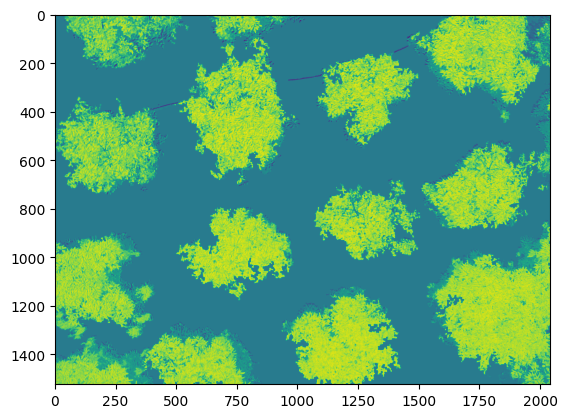

In [36]:
plt.imshow(seg_ndvi)

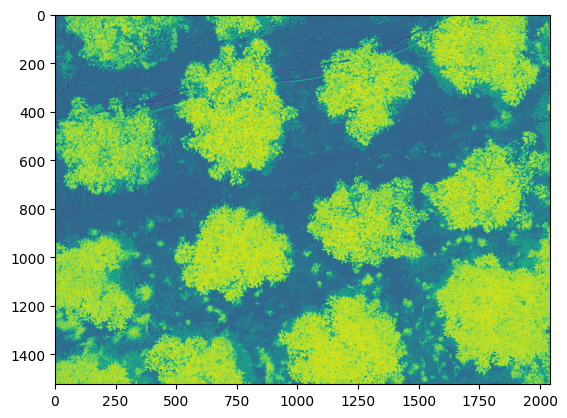

In [15]:
plt.imshow(ndvi)

C:\Users\antho\AppData\Local\Temp\ipykernel_25500\1866502226.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap(cmap)


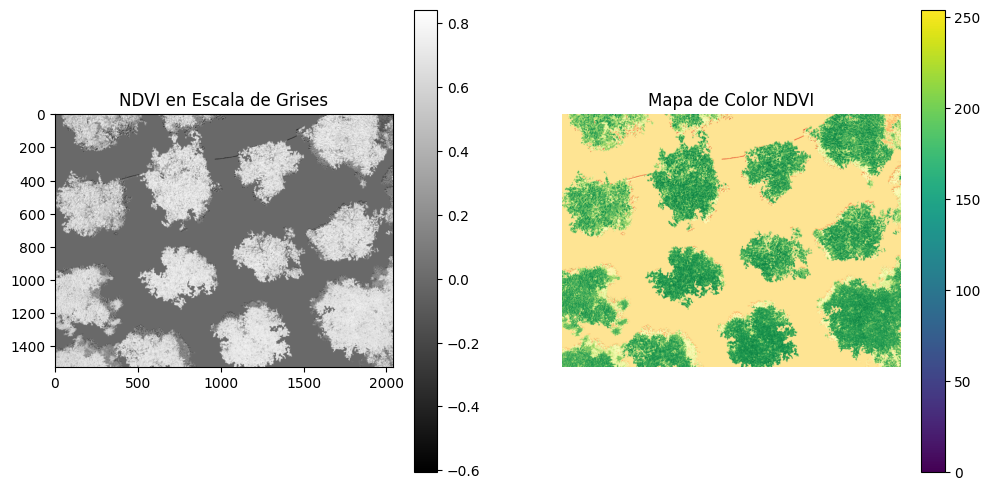

In [37]:
def generate_ndvi_colormap(ndvi, cmap="RdYlGn"):
    """
    Genera un mapa de color basado en NDVI.
    - ndvi: Matriz con los valores de NDVI.
    - cmap: Nombre del mapa de colores (por defecto 'RdYlGn').
    """
    # Escalar valores de NDVI a rango de 0 a 1 para la visualización
    ndvi_normalized = (ndvi - ndvi.min()) / (ndvi.max() - ndvi.min())
    
    # Crear un mapa de color
    colormap = plt.cm.get_cmap(cmap)
    ndvi_colored = colormap(ndvi_normalized)
    
    # Convertir a formato uint8 para visualizar con OpenCV
    ndvi_colored = (ndvi_colored[:, :, :3] * 255).astype(np.uint8)
    return ndvi_colored

def display_ndvi_map(ndvi, ndvi_colormap):
    """
    Muestra el NDVI en escala de grises y el mapa de color.
    """
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("NDVI en Escala de Grises")
    plt.imshow(ndvi, cmap="gray")
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    plt.title("Mapa de Color NDVI")
    plt.imshow(ndvi_colormap)
    plt.axis("off")
    plt.colorbar()
    plt.show()



# Calcular NDVI
ndvi_max, ndvi_min = seg_ndvi.max(), seg_ndvi.min()

# Generar el mapa de color
ndvi_colormap = generate_ndvi_colormap(seg_ndvi)

# Mostrar resultados
display_ndvi_map(seg_ndvi, ndvi_colormap)

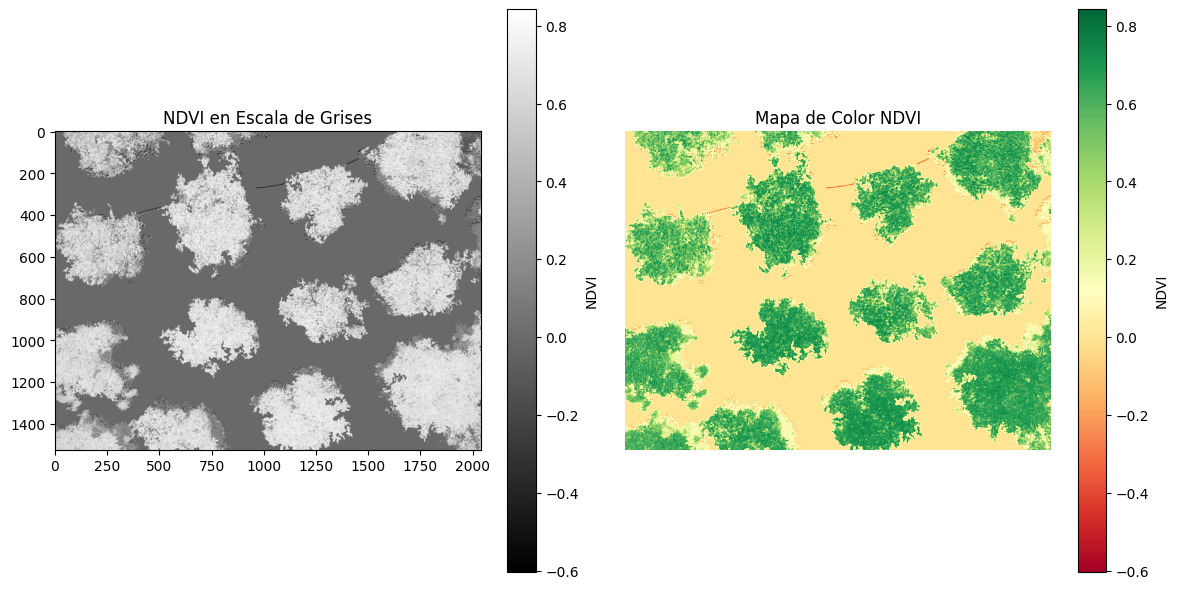

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Función para mostrar el mapa de NDVI
def display_ndvi_map(ndvi):
    """
    Muestra el NDVI en escala de grises y con un mapa de color.
    """
    # Crear un mapa de colores y normalizar
    cmap = "RdYlGn"
    norm = plt.Normalize(vmin=ndvi.min(), vmax=ndvi.max())

    # Crear la figura
    plt.figure(figsize=(12, 6))
    
    # Primer gráfico: NDVI en escala de grises
    ax1 = plt.subplot(1, 2, 1)
    im1 = ax1.imshow(ndvi, cmap="gray")
    ax1.set_title("NDVI en Escala de Grises")
    plt.colorbar(im1, ax=ax1, label="NDVI")
    
    # Segundo gráfico: NDVI con mapa de colores
    ax2 = plt.subplot(1, 2, 2)
    im2 = ax2.imshow(ndvi, cmap=cmap, norm=norm)
    ax2.set_title("Mapa de Color NDVI")
    plt.colorbar(im2, ax=ax2, label="NDVI")
    ax2.axis("off")
    
    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()



# Mostrar el mapa de NDVI
display_ndvi_map(seg_ndvi)

C:\Users\antho\AppData\Local\Temp\ipykernel_25500\2124178739.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap)


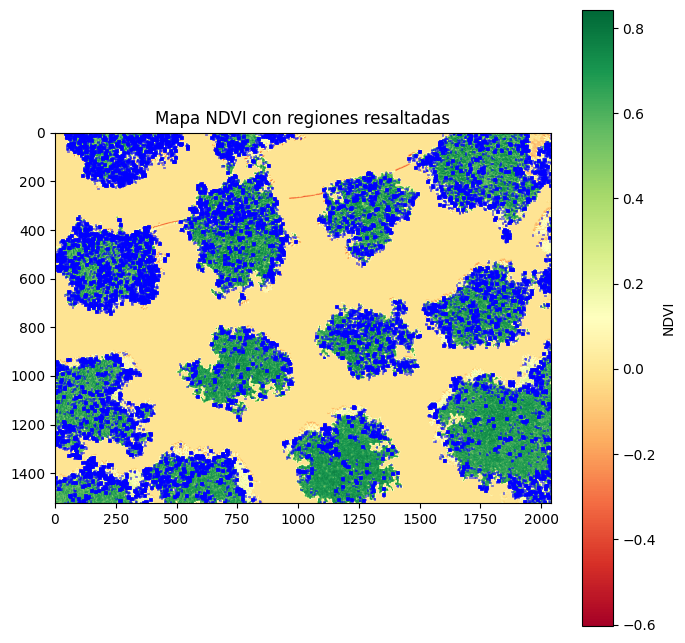

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, find_objects

# Resaltar regiones en la imagen
def highlight_regions(ndvi, mask, cmap="RdYlGn"):
    """
    Muestra el NDVI resaltando regiones que cumplen con la máscara.
    """
    # Crear la figura
    plt.figure(figsize=(8, 8))
    plt.title("Mapa NDVI con regiones resaltadas")

    # Mostrar el NDVI con mapa de colores
    cmap = plt.cm.get_cmap(cmap)
    norm = plt.Normalize(vmin=ndvi.min(), vmax=ndvi.max())
    plt.imshow(ndvi, cmap=cmap, norm=norm)
    plt.colorbar(label="NDVI")

    # Dibujar contornos en las áreas resaltadas
    labeled, _ = label(mask)
    for region in find_objects(labeled):
        y, x = region
        plt.gca().add_patch(plt.Rectangle((x.start, y.start), x.stop - x.start, y.stop - y.start,
                                          edgecolor="blue", facecolor="none", lw=2))

    # Mostrar gráfico
    plt.show()
# Generar datos de ejemplo (rango entre -1 y 1)
ndvi_mask = (seg_ndvi > 0.35) & (seg_ndvi < 0.40)
# Llamar a la función para visualizar
highlight_regions(seg_ndvi, ndvi_mask)